# ARIMA Using Historical Oil Prices

In [46]:
! pip install nasdaq-data-link
! pip install pmdarima

In [28]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
import nasdaqdatalink
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from numpy import log
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import acf
import pmdarima as pm

In [2]:
oil = pd.read_csv("C:/Users/Admin/Desktop/Data Capstone/Oil_Price.csv")
oil

,Date,Value
0,2003-01-02,30.05
1,2003-01-03,30.83
2,2003-01-06,30.71
3,2003-01-07,29.72
4,2003-01-08,28.86
...,...,...
4961,2022-03-25,115.99
4962,2022-03-28,113.39
4963,2022-03-29,110.05
4964,2022-03-30,110.46


In [3]:
result = adfuller(oil.Value.dropna())
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])

ADF Statistic: -2.462680
p-value: 0.124821


Since the P > 0.05 we need to difference the series since it is not initially stationary.

In [4]:
oil_df = pd.DataFrame(oil)

oil_df.Date = pd.to_datetime(oil_df.Date)
oil_df

,Date,Value
0,2003-01-02,30.05
1,2003-01-03,30.83
2,2003-01-06,30.71
3,2003-01-07,29.72
4,2003-01-08,28.86
...,...,...
4961,2022-03-25,115.99
4962,2022-03-28,113.39
4963,2022-03-29,110.05
4964,2022-03-30,110.46


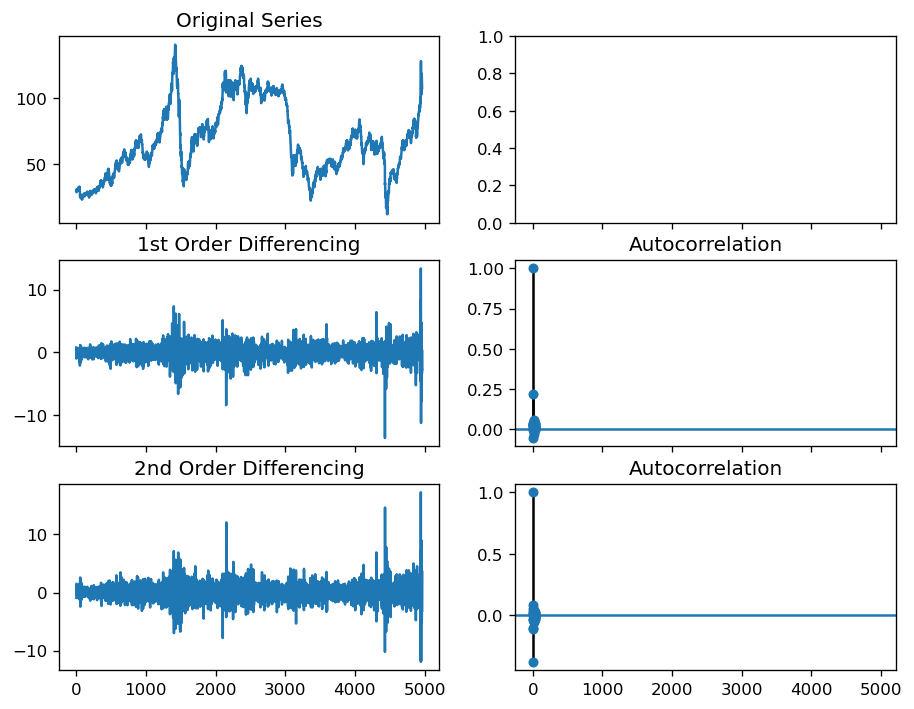

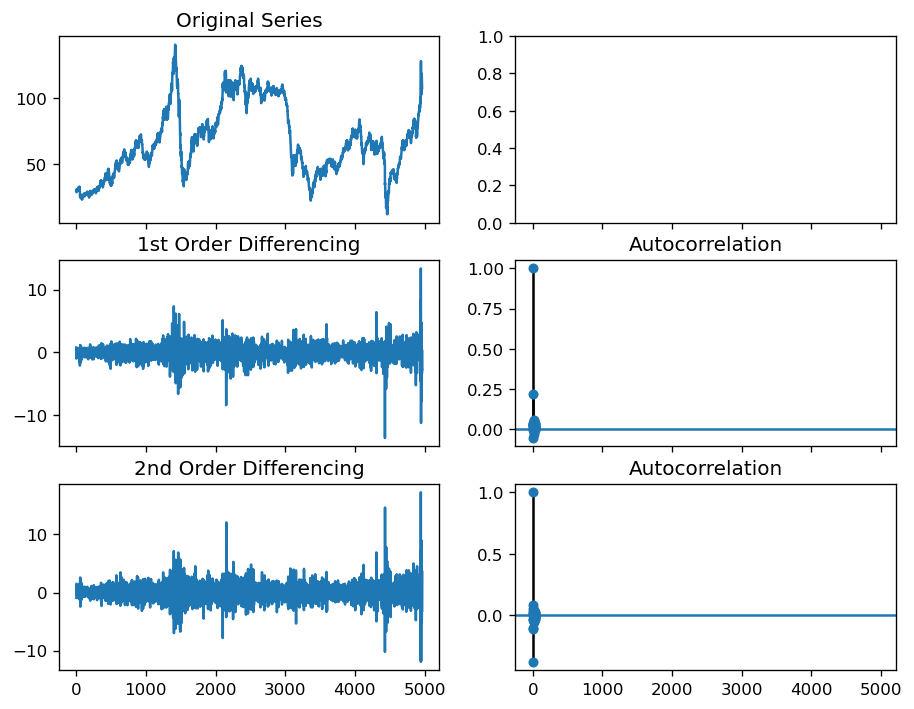

In [5]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Differencing
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(oil_df.Value); axes[0, 0].set_title('Original Series')
#plot_acf(oil_df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(oil_df.Value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(oil_df.Value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(oil_df.Value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(oil_df.Value.diff().diff().dropna(), ax=axes[2, 1])

The series reaches stationarity after two orders of differencing but we will take order of differencing as 1 since the second one goes in to negative

In [6]:
y = oil_df.Value

In [7]:
## Adf Test
ndiffs(y, test='adf')  # 2

1

In [8]:
# KPSS test
ndiffs(y, test='kpss')  # 1

1

In [9]:
# PP test
ndiffs(y, test='pp')  # 1

1

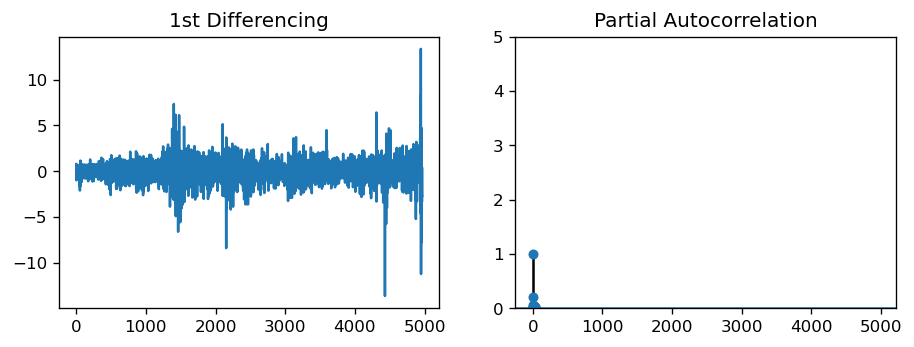

In [10]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(oil_df.Value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(oil_df.Value.diff().dropna(), ax=axes[1])

plt.show()

We will fix, or the AR term as p = 1

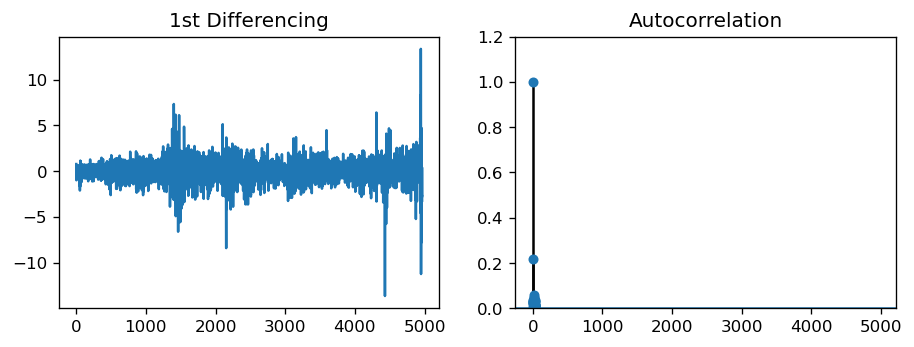

In [11]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(oil_df.Value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(oil_df.Value.diff().dropna(), ax=axes[1])

plt.show()

We will take the MA order to be q = 1 since only the first lagg exceeds the blue area

In [12]:
# 1,1,1 ARIMA

model = ARIMA(oil_df.Value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 4965
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7557.974
Method:                       css-mle   S.D. of innovations              1.109
Date:                Tue, 03 May 2022   AIC                          15123.949
Time:                        10:10:28   BIC                          15149.989
Sample:                             1   HQIC                         15133.079
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0155      0.020      0.789      0.430      -0.023       0.054
ar.L1.D.Value     0.1204      0.063      1.902      0.057      -0.004       0.244
ma.L1.D.Value     0.1008      0.063     

In [53]:
# 1,1,2 ARIMA

model = ARIMA(oil_df.Value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 4965
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -7557.831
Method:                       css-mle   S.D. of innovations              1.109
Date:                Tue, 03 May 2022   AIC                          15125.661
Time:                        10:28:00   BIC                          15158.212
Sample:                             1   HQIC                         15137.074
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0156      0.020      0.794      0.427      -0.023       0.054
ar.L1.D.Value    -0.1606      0.303     -0.531      0.596      -0.754       0.433
ma.L1.D.Value     0.3820      0.302     

The second ARIMA model we created is far better since the MA1 and AR1 P>|z| values are signifficant, i.e., less than 0.05

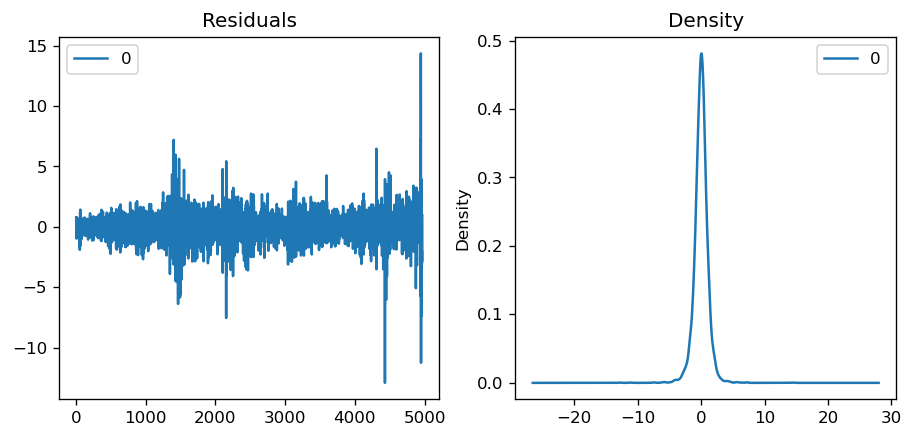

In [54]:
plt.rcParams.update({'figure.figsize':(9,4), 'figure.dpi':120})

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

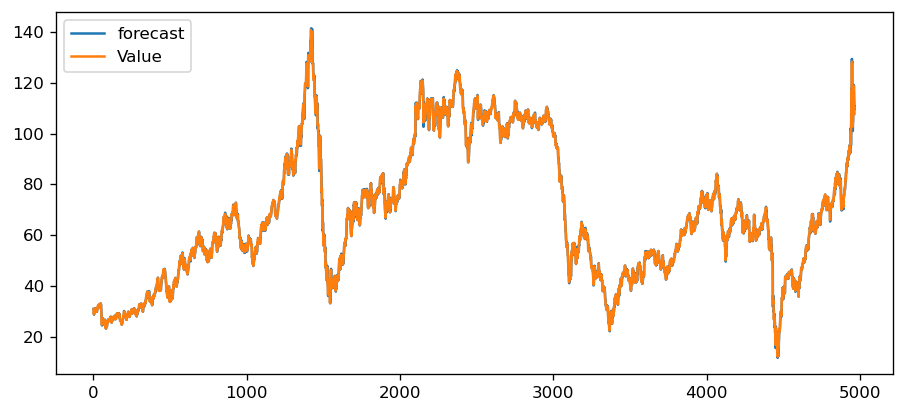

In [55]:
model_fit.plot_predict(dynamic=False)
plt.show()

# Out-of-Time Cross Validation

In [56]:
# Create Training and Test
train = oil_df.Value[:4800]
test = oil_df.Value[4800:]

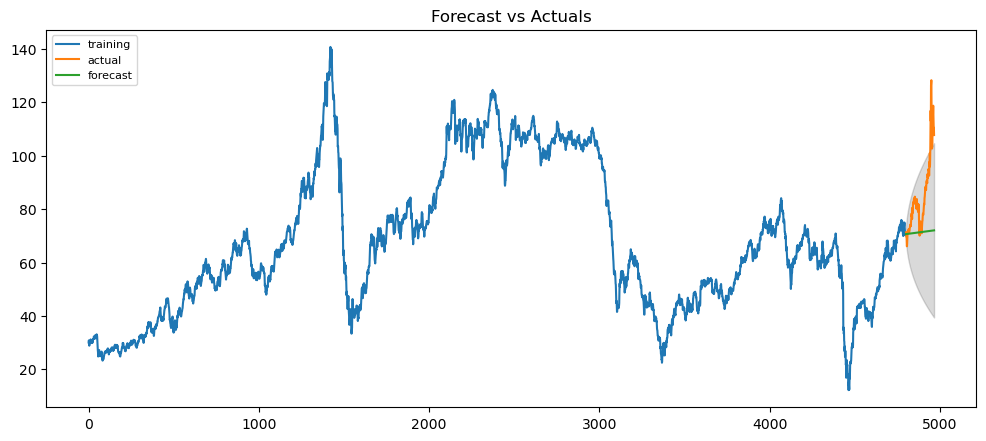

In [58]:
# Build Model
 
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(166, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [59]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

D:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.14365346329428544,
 'me': -13.501467402946588,
 'mae': 13.733954974161739,
 'mpe': -0.14021276302153063,
 'rmse': 19.079693415282502,
 'acf1': 0.9742326276246762,
 'corr': 0.813141751832562,
 'minmax': 0.14357605636558968}

Arround 14.3% MAPE implies the model is about 85.7% accurate in predicting the next 15 observations.

# Auto ARIMA

In [60]:
model = pm.auto_arima(oil_df.Value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15123.949, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15360.229, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15124.388, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15125.482, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15359.171, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15125.938, Time=1.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15125.971, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15123.820, Time=0.53 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=15125.675, Time=0.74 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15117.279, Time=2.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=15079.233, Time=7.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15114.904, Time=4.52 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=15078.747, Time=7.88 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=15120.631, Time=5.31 sec
 ARIMA(3,1,3)(0,0,0

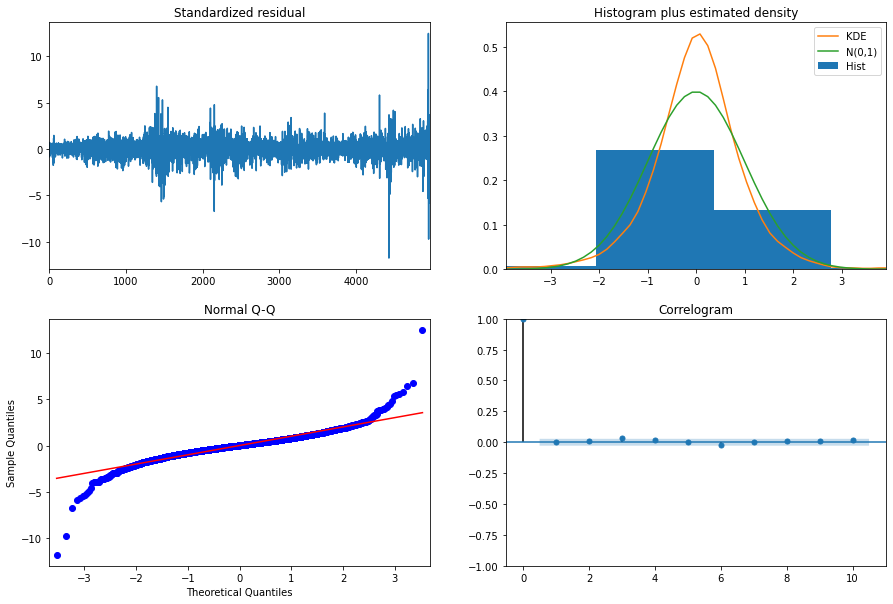

In [32]:
model.plot_diagnostics(figsize=(15,10))
plt.show()

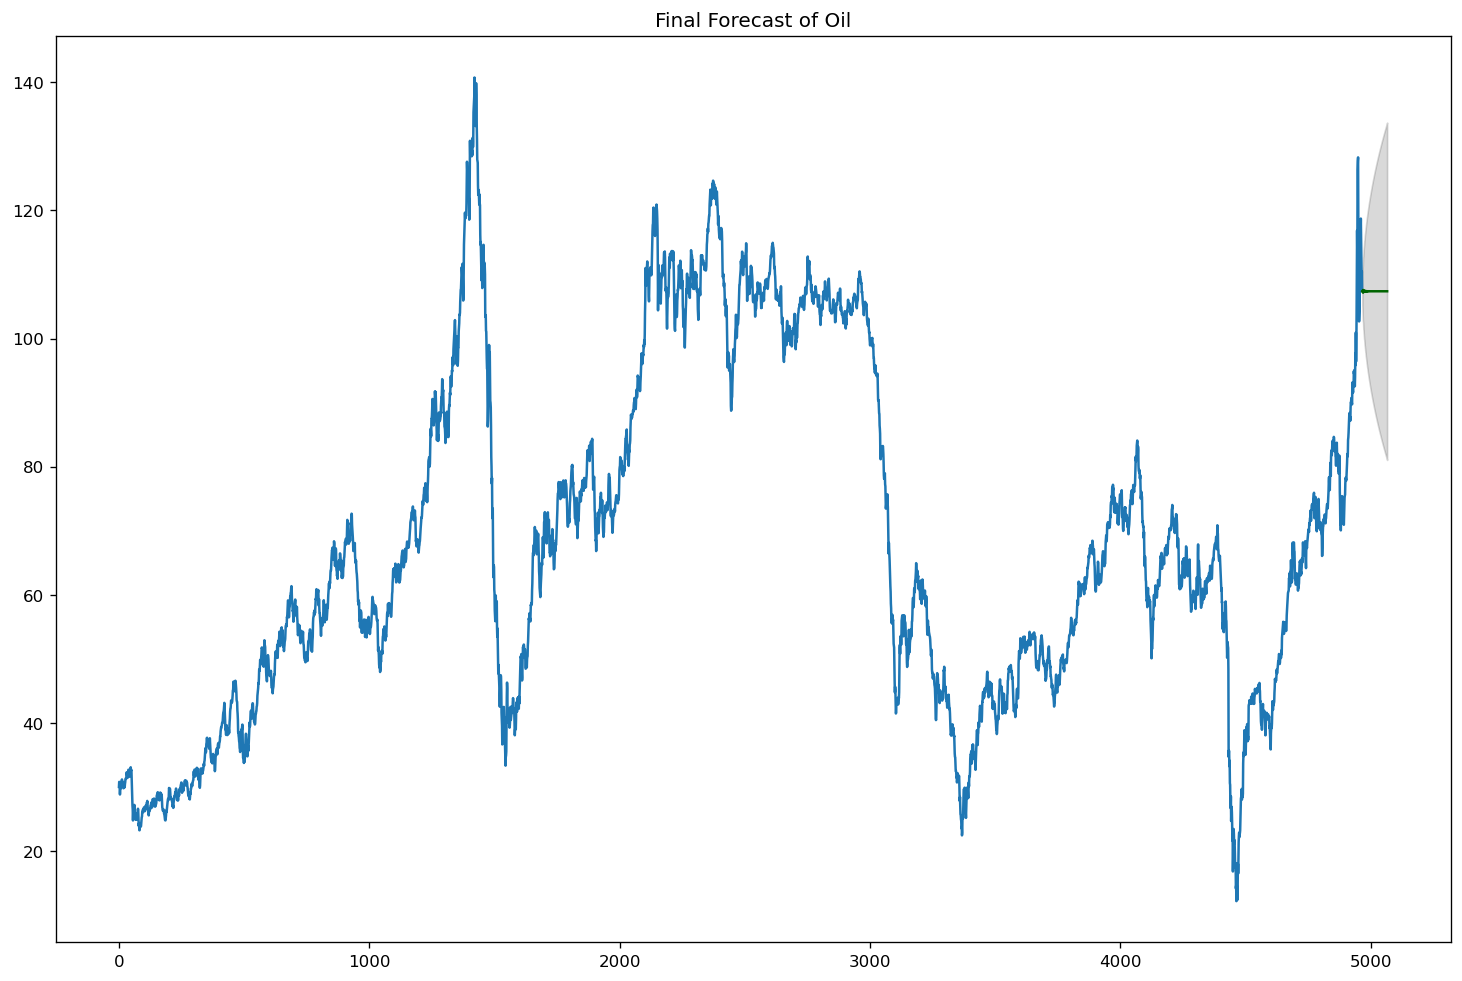

In [43]:
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})


# Forecast
n_periods = 100
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(oil_df.Value), len(oil_df.Value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(oil_df.Value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title("Final Forecast of Oil")
plt.show()